In [ ]:
##### SETTINGS #####

# GENERAL
RANDOM_SEED = 42

# TOKENIZER
MAX_LENGTH = 512

# DATA SPLITTING
TEST_SIZE = 0.2
VALIDATION_SIZE = 0.2

# TRAINING ARGUMENTS
NUM_LABELS = 3
LABEL_NAMES = ['negative', 'neutral', 'positive']
EPOCHS = 2
LEARNING_RATE = 2e-5
BATCH_SIZE = 8
WARMUP_STEPS = 100
WEIGHT_DECAY = 1e-8

# MODEL
HUGG_TOKENIZER = 'BertTokenizer'
ML_MODEL = 'bert-base-uncased'
UNFREEZED_PERIODS = 1
FREEZED_LAYERS = 5

In [ ]:
import tensorflow as tf
import torch

# Get the GPU device name.
device_name = tf.test.gpu_device_name()
# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    print('GPU device not found')

# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
import pandas as pd
import glob

path = r'/content/drive/MyDrive/Colab Notebooks/data/' # use your path
all_files = glob.glob(path + "/*.txt")

li = []

for filename in all_files:
    df = pd.read_table(filename, header=None, names=['id', 'sentiment', 'tweet'])
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)[['sentiment', 'tweet']].dropna()

def to_sentiment(rating):
    if rating == 'negative':
        return 0
    elif rating == 'neutral':
        return 1
    else:
        return 2

df['sentiment'] = df.sentiment.apply(to_sentiment)

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_SEED)

# Get the lists of sentences and their labels.
reviews = df_train.tweet.values
labels = df_train.sentiment.values

# Report the number of sentences.
print('Number of Tweets for the Model: {:,}\n'.format(df_train.shape[0]))
# Display 10 random rows from the data.
df_train.sample(10)

Number of Tweets for the Model: 23,608



,sentiment,tweet
2739,2,If you're attending #NYCC make sure to catch t...
1783,2,@gbkburgers if i were Queen for the Day i'd kn...
14872,1,Obama's DOJ record on protecting voting rights...
22162,2,@froggy1013 it's good! Drink in my hand- eric ...
10357,1,Might have to make that Final Destination 5 mo...
20140,1,Aktuell: Reports: Angela Merkel set for 4th te...
3349,2,It's Friday so I'm washing my hair with loreal...
21146,2,Representing Bob Marley on our own show day - ...
16051,2,Going to Singapore tonight :) Excited for Skyf...
27682,1,@valerietxw nope not quite yet... Do u read ch...


In [ ]:
!pip install transformers
!pip install wget

tokenizer_to_use = getattr(__import__('transformers', fromlist=[HUGG_TOKENIZER]), HUGG_TOKENIZER)

# Load the BERT tokenizer.
print('Loading {:} tokenizer...'.format(HUGG_TOKENIZER))
tokenizer = tokenizer_to_use.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BertTokenizer tokenizer...


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
tokens = []

for rev in reviews:
    encoded_rev = tokenizer.encode(rev, add_special_tokens = True)
    token_rev = tokenizer.convert_ids_to_tokens(encoded_rev)

    input_ids.append(encoded_rev)
    tokens.append(token_rev)

print('==== Example ====\n')
print('Original: ', reviews[0])
print('Tokenized:', tokens[0])
print('Token IDs:', input_ids[0])

Token indices sequence length is longer than the specified maximum sequence length for this model (588 > 512). Running this sequence through the model will result in indexing errors


==== Example ====

Original:  So, @ChuckRagan in Helsinki tonight with the #RevivalTour, and he has a birthday! Sounds like a killer combination. Too bad its Tuesday.
Tokenized: ['[CLS]', 'so', ',', '@', 'chuck', '##ragan', 'in', 'helsinki', 'tonight', 'with', 'the', '#', 'revival', '##tour', ',', 'and', 'he', 'has', 'a', 'birthday', '!', 'sounds', 'like', 'a', 'killer', 'combination', '.', 'too', 'bad', 'its', 'tuesday', '.', '[SEP]']
Token IDs: [101, 2061, 1010, 1030, 8057, 28905, 1999, 12331, 3892, 2007, 1996, 1001, 6308, 21163, 1010, 1998, 2002, 2038, 1037, 5798, 999, 4165, 2066, 1037, 6359, 5257, 1012, 2205, 2919, 2049, 9857, 1012, 102]


In [ ]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  2309


In [ ]:
from keras.preprocessing.sequence import pad_sequences

print('\nPadding / Truncating all Sentences to %d Values...' % MAX_LENGTH)
print('\nPadding Token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))
# Pad our input tokens with value 0. "post" indicates that we want to pad and truncate at the end of the sequence
input_ids = pad_sequences(input_ids, maxlen=MAX_LENGTH, dtype="long", value=0, truncating="post", padding="post")

print('Done...')
print('\n==== Example ====\n')
print('Padded / Trunctated Example: ', list(input_ids[0]))


Padding / Truncating all Sentences to 512 Values...

Padding Token: "[PAD]", ID: 0
Done...

==== Example ====

Padded / Trunctated Example:  [101, 2061, 1010, 1030, 8057, 28905, 1999, 12331, 3892, 2007, 1996, 1001, 6308, 21163, 1010, 1998, 2002, 2038, 1037, 5798, 999, 4165, 2066, 1037, 6359, 5257, 1012, 2205, 2919, 2049, 9857, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
attention_masks = []
for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks.append(att_mask)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=RANDOM_SEED, test_size=VALIDATION_SIZE)
train_masks, validation_masks, tl, rl = train_test_split(attention_masks, labels, random_state=RANDOM_SEED, test_size=VALIDATION_SIZE)

# Convert all inputs and labels into torch tensors, the required datatype for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)
# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)

print('Number of Reviews to train Model on: {:,}\n'.format(len(train_data)))
print('Number of Reviews for Validation: {:,}\n'.format(len(validation_data)))

Number of Reviews to train Model on: 18,886

Number of Reviews for Validation: 4,722



In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(ML_MODEL, num_labels=NUM_LABELS, output_attentions=False, output_hidden_states=False)

# Tell pytorch to run this model on the GPU.
if device.type == 'cuda': model.cuda() 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())
print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== First Transformer ====\n')
for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== Output Layer ====\n')
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# All based on https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128
from tqdm.auto import tqdm
import random
from transformers import get_cosine_schedule_with_warmup

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=WEIGHT_DECAY)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS, num_training_steps=len(train_dataloader)*EPOCHS)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

# Store the average loss after each epoch so we can plot them.
train_loss = []
train_accuracy = []
validation_loss = []
validation_accuracy = []

outer = tqdm(total=len(train_dataloader)*EPOCHS, desc='Training', position=0)
print("")
print('\n========================================================\n Training with all Layers unfrozen for {:} Epochs... \n========================================================'.format(UNFREEZED_PERIODS))


for epoch_i in range(0, UNFREEZED_PERIODS):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, EPOCHS))
    print("")
    
    t0 = time.time()
    
    # Reset the total loss for this epoch.
    total_loss, total_eval_loss, total_acc, total_lr, nb_train_steps = 0, 0, 0, 0, 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    for step, batch in enumerate(tqdm(train_dataloader, desc='Epoch', leave=False)):


        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

        # Update the number of steps
        nb_train_steps += 1

        # Accumulate the learning rate
        total_lr += scheduler.get_last_lr()[0]

        # Accumulate the accuracy
        total_acc += flat_accuracy(outputs[1].detach().cpu().numpy(), b_labels.to('cpu').numpy())

        outer.update(1)

        # Print out
        if step % round(len(train_dataloader)/5) == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Elapsed: {:}.  Batch {:>5,} of {:>5,}.  \u00F8 Training Loss: {:.2f}.  \u00F8 Training Accuracy: {:.2f}.  \u00F8 Learning Rate: {:.2}.'.format(elapsed, step, len(train_dataloader), (total_loss/nb_train_steps), (total_acc/nb_train_steps), (total_lr/nb_train_steps)))
    

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    avg_train_acc = total_acc / len(train_dataloader)          
    
    # Store the loss value for plotting the learning curve.
    train_loss.append(avg_train_loss)
    train_accuracy.append(avg_train_acc)

    # Print out the epoch summary
    print("")
    print("-----------------------------\n Training Result of Epoch {:} \n-----------------------------".format(epoch_i+1))
    print("  Training Loss: {0:.2f}".format(avg_train_loss))
    print("  Training Accuracy: {0:.2f}".format(avg_train_acc))
    print("  Training Epoch took: {:}".format(format_time(time.time() - t0)))
    


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on our validation set.

    print("")
    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in tqdm(validation_dataloader, desc='Validation', leave=False):
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():        
            # Forward pass, calculate logit predictions.
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        
        # Get the "loss" output by the model
        loss = outputs[0]
        total_eval_loss += loss.item()

        # Get the "logits" output by the model
        logits = outputs[1]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Accumulate the total accuracy.
        eval_accuracy += flat_accuracy(logits, label_ids)

        # Track the number of batches
        nb_eval_steps += 1
    
    # Store the loss value for plotting the learning curve.
    validation_loss.append(total_eval_loss/nb_eval_steps)
    validation_accuracy.append(eval_accuracy/nb_eval_steps)

    # Report the final accuracy for this validation run.
    print("-----------------------------\n Validation Result of Epoch {:} \n-----------------------------".format(epoch_i+1))
    print("  Validation Loss: {0:.2f}".format(total_eval_loss/nb_eval_steps))
    print("  Validation Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))


for epoch_i in range(UNFREEZED_PERIODS, EPOCHS):
    
    # ========================================
    #               Training
    # ========================================

    print("")
    print("")
    print("")
    print("========================================================\n Freezing the Embedding Layers and the first {:} Encoders... \n========================================================".format(FREEZED_LAYERS))
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, EPOCHS))
    print("")
    
    t0 = time.time()
    
    # Reset the total loss for this epoch.
    total_loss, total_eval_loss, total_acc, total_lr, nb_train_steps = 0, 0, 0, 0, 0

    # To avoid forgetting freezing lower layers
    modules = [model.bert.embeddings, *model.bert.encoder.layer[:FREEZED_LAYERS]]
    for module in modules:
        for param in module.parameters():
            param.requires_grad = False

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()


    for step, batch in enumerate(tqdm(train_dataloader, desc='Epoch', leave=False)):
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

        # Update the number of steps
        nb_train_steps += 1

        # Accumulate the learning rate
        total_lr += scheduler.get_last_lr()[0]

        # Accumulate the accuracy
        total_acc += flat_accuracy(outputs[1].detach().cpu().numpy(), b_labels.to('cpu').numpy())

        outer.update(1)

        # Print out
        if step % round(len(train_dataloader)/5) == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Elapsed: {:}.  Batch {:>5,} of {:>5,}.  \u00F8 Training Loss: {:.2f}.  \u00F8 Training Accuracy: {:.2f}.  \u00F8 Learning Rate: {:.2}.'.format(elapsed, step, len(train_dataloader), (total_loss/nb_train_steps), (total_acc/nb_train_steps), (total_lr/nb_train_steps)))
    
    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    avg_train_acc = total_acc / len(train_dataloader)          
    
    # Store the loss value for plotting the learning curve.
    train_loss.append(avg_train_loss)
    train_accuracy.append(avg_train_acc)

    # Freeze one more layer every epoche
    FREEZED_LAYERS += 1

    # Print out the epoch summary
    print("")
    print("-----------------------------\n Training Result of Epoch {:} \n-----------------------------".format(epoch_i+1))
    print("  Training Loss: {0:.2f}".format(avg_train_loss))
    print("  Training Lccuracy: {0:.2f}".format(avg_train_acc))
    print("  Training Epoch took: {:}".format(format_time(time.time() - t0)))
    


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on our validation set.

    print("")
    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in tqdm(validation_dataloader, desc='Validation', leave=False):
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():        
            # Forward pass, calculate logit predictions.
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        
        # Get the "loss" output by the model
        loss = outputs[0]
        total_eval_loss += loss.item()

        # Get the "logits" output by the model
        logits = outputs[1]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Accumulate the total accuracy.
        eval_accuracy += flat_accuracy(logits, label_ids)

        # Track the number of batches
        nb_eval_steps += 1

    # Store the loss value for plotting the learning curve.
    validation_loss.append(total_eval_loss/nb_eval_steps)
    validation_accuracy.append(eval_accuracy/nb_eval_steps)

    # Report the final accuracy for this validation run.
    print("-----------------------------\n Validation Result of Epoch {:} \n-----------------------------".format(epoch_i+1))
    print("  Validation Loss: {0:.2f}".format(total_eval_loss/nb_eval_steps))
    print("  Validation Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))



print("")
print("Training complete!")



 Training with all Layers unfrozen for 1 Epochs... 


======== Epoch 1 / 2 ========



  Elapsed: 0:06:12.  Batch   472 of 2,361.  ø Training Loss: 0.83.  ø Training Accuracy: 0.60.  ø Learning Rate: 1.8e-05.
  Elapsed: 0:12:21.  Batch   944 of 2,361.  ø Training Loss: 0.78.  ø Training Accuracy: 0.63.  ø Learning Rate: 1.8e-05.
  Elapsed: 0:18:30.  Batch 1,416 of 2,361.  ø Training Loss: 0.75.  ø Training Accuracy: 0.66.  ø Learning Rate: 1.8e-05.
  Elapsed: 0:24:40.  Batch 1,888 of 2,361.  ø Training Loss: 0.73.  ø Training Accuracy: 0.67.  ø Learning Rate: 1.7e-05.
  Elapsed: 0:30:49.  Batch 2,360 of 2,361.  ø Training Loss: 0.71.  ø Training Accuracy: 0.68.  ø Learning Rate: 1.6e-05.

-----------------------------
 Training Result of Epoch 1 
-----------------------------
  Training Loss: 0.71
  Training Accuracy: 0.68
  Training Epoch took: 0:30:49



-----------------------------
 Validation Result of Epoch 1 
-----------------------------
  Validation Loss: 0.59
  Validation Accuracy: 0.73
  Validation took: 0:02:43



 Freezing the Embedding Layers and the first 5 Encoders... 

======== Epoch 2 / 2 ========



  Elapsed: 0:04:39.  Batch   472 of 2,361.  ø Training Loss: 0.46.  ø Training Accuracy: 0.81.  ø Learning Rate: 8.7e-06.
  Elapsed: 0:09:18.  Batch   944 of 2,361.  ø Training Loss: 0.46.  ø Training Accuracy: 0.81.  ø Learning Rate: 7.2e-06.
  Elapsed: 0:13:57.  Batch 1,416 of 2,361.  ø Training Loss: 0.45.  ø Training Accuracy: 0.82.  ø Learning Rate: 5.8e-06.
  Elapsed: 0:18:35.  Batch 1,888 of 2,361.  ø Training Loss: 0.45.  ø Training Accuracy: 0.82.  ø Learning Rate: 4.7e-06.
  Elapsed: 0:23:14.  Batch 2,360 of 2,361.  ø Training Loss: 0.45.  ø Training Accuracy: 0.82.  ø Learning Rate: 3.8e-06.

-----------------------------
 Training Result of Epoch 2 
-----------------------------
  Training Loss: 0.45
  Training Lccuracy: 0.82
  Training Epoch took: 0:23:14



-----------------------------
 Validation Result of Epoch 2 
-----------------------------
  Validation Loss: 0.66
  Validation Accuracy: 0.74
  Validation took: 0:02:43

Training complete!


In [ ]:
!pip install pytorch_transformers
import os
from pytorch_transformers import WEIGHTS_NAME, CONFIG_NAME

output_dir = "/content/drive/MyDrive/Colab Notebooks/models/"

# Step 1: Save a model, configuration and vocabulary that you have fine-tuned

# If we have a distributed model, save only the encapsulated model
# (it was wrapped in PyTorch DistributedDataParallel or DataParallel)
model_to_save = model.module if hasattr(model, 'module') else model

# If we save using the predefined names, we can load using `from_pretrained`
output_model_file = os.path.join(output_dir, WEIGHTS_NAME)
output_config_file = os.path.join(output_dir, CONFIG_NAME)

torch.save(model_to_save.state_dict(), output_model_file)
model_to_save.config.to_json_file(output_config_file)
tokenizer.save_vocabulary(output_dir)

('/content/drive/MyDrive/Colab Notebooks/models/vocab.txt',)

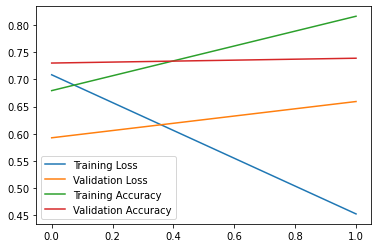

In [ ]:
import plotly.express as px
f = pd.DataFrame(np.asarray([train_loss, validation_loss, train_accuracy, validation_accuracy]), index = ['Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy']).T
f.plot()

In [ ]:
reviews = df_test.tweet.values
labels = df_test.sentiment.values

input_ids = []
for rev in reviews:
    encoded_sent = tokenizer.encode(
                        rev,
                        add_special_tokens = True,
                   )
    input_ids.append(encoded_sent)

input_ids = pad_sequences(input_ids, maxlen=MAX_LENGTH, dtype="long", truncating="post", padding="post")

attention_masks = []
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=BATCH_SIZE)

In [ ]:
# Prediction on test set
print('Predicting labels for {:,} test reviews...'.format(len(prediction_inputs)))
# Put model in evaluation mode
model.eval()
# Tracking variables 
predictions, true_labels, probas = [], [], []
# Predict 
for batch in prediction_dataloader:

    m = torch.nn.Softmax(dim=1)
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        model.to(device)
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)
    logits = outputs[0]
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    probabilities = m(outputs[0]).to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)
    probas.append(probabilities)
print('DONE.')

Predicting labels for 5,902 test reviews...
DONE.


              precision    recall  f1-score   support

    negative       0.65      0.64      0.65       936
     neutral       0.69      0.69      0.69      2380
    positive       0.77      0.78      0.78      2586

    accuracy                           0.72      5902
   macro avg       0.71      0.70      0.70      5902
weighted avg       0.72      0.72      0.72      5902



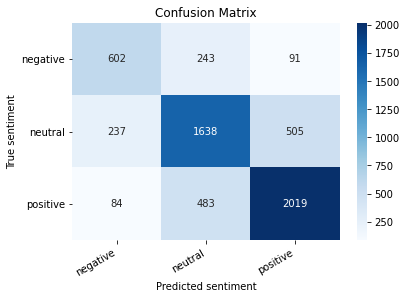

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');
    plt.title('Confusion Matrix')

predited_labels = np.argmax(np.vstack(predictions), axis=1).flatten()
true_labels = np.concatenate(true_labels)

# Print the Results
show_confusion_matrix(pd.DataFrame(confusion_matrix(true_labels, predited_labels), index=LABEL_NAMES, columns=LABEL_NAMES))
print(classification_report(true_labels, predited_labels, target_names=LABEL_NAMES))

@garrettc Do you think it knows that in a couple of hours it may be
one step closer to obsolescence (and outpaced by a giant iPad at that)

True sentiment: neutral



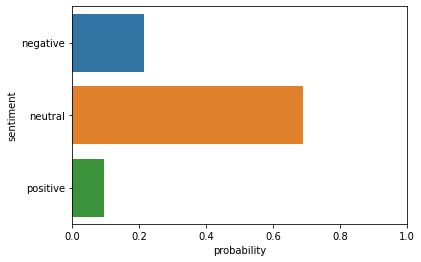

In [ ]:
from textwrap import wrap

idx = 14

review_text = reviews[idx]
true_sentiment = labels[idx]

pred_df = pd.DataFrame({
  'class_names': LABEL_NAMES,
  'values': np.vstack(probas)[idx]
})

print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {LABEL_NAMES[true_sentiment]}')
print()

sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);